In [103]:
import numpy as np
from visualise import plot_digi_fig
import matplotlib.pyplot as plt 
from dataloader import FFT_transform
from dataloader import FFT_transform_PM
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

In [176]:
#the following code is mainly based on code from https://www.datadriveninvestor.com/2020/10/23/fourier-transform-for-image-processing-in-python-from-scratch/
def distance(point1, point2):
    val=np.sqrt((point1[0]-point2[0])**2+point1[1]-point2[1]**2)
    val=np.nan_to_num(val)
    return val
    
def gaussianLP(D0,imgShape):
    base=np.zeros(imgShape[:2])
    rows,cols=imgShape[:2]
    center=(rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x]=np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def gaussianHP(D0,imgShape):
    base=np.zeros(imgShape[:2])
    rows,cols=imgShape[:2]
    center=(rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x]=1-np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def butterworthLP(D0,imgShape):
    M,N=mat_r.shape
    H=np.zeros((M,N), dtype=np.float32)
#D0=10
    n=0.5
    for u in range(M):
        for v in range(N):
            D=np.sqrt((u-M/2)**2+(v-N/2)**2)
            H[u,v]=1/(1+(D/D0)**(2*n))
    return H

def butterworthHP(D0,imgShape):
    M,N=mat_r.shape
    H=np.zeros((M,N), dtype=np.float32)
#D0=10
    n=0.5
    for u in range(M):
        for v in range(N):
            D=np.sqrt((u-M/2)**2+(v-N/2)**2)
            H[u,v]=1-(1/(1+(D/D0)**(2*n)))
    return H

       

<_io.TextIOWrapper name='Data/train_4.txt' mode='r' encoding='cp1252'>
[[0 0 0 2 6 6 6 6 5 0 0 0 0 0 0]
 [0 0 0 1 6 6 6 6 6 0 0 0 0 0 0]
 [0 0 0 0 6 6 6 6 6 0 0 0 0 0 0]
 [0 0 0 2 6 6 6 6 6 0 0 0 0 0 0]
 [0 0 1 5 6 6 6 6 3 0 0 0 0 0 0]
 [0 0 6 6 6 6 6 3 0 0 0 0 0 0 0]
 [0 1 6 6 6 6 3 0 0 0 0 3 6 5 1]
 [0 5 6 6 6 6 0 0 0 3 6 6 6 6 3]
 [2 6 6 6 6 6 1 0 0 4 6 6 6 6 5]
 [6 6 6 6 6 6 6 4 2 5 6 6 6 6 6]
 [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
 [1 4 4 4 4 4 2 2 2 5 6 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 1 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 6 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 5 6 6 6]
 [0 0 0 0 0 0 0 0 0 0 0 1 4 4 3]]
15
16
[[ 14.0316923   27.88545373  29.44438979  53.36993927  40.73165967
   57.24540879  40.56166174  32.18875825  40.56166174  57.24540879
   40.73165967  53.36993927  29.44438979  27.88545373  14.0316923 ]
 [ 33.79756238  24.8576734   -6.92848349  34.47647639  41.5457205
   43.93725079  55.86817187  53.96804565  55.23427186  37.30862828
   48.40728876  48.23104217  47.07978826  16.32305005  24.3

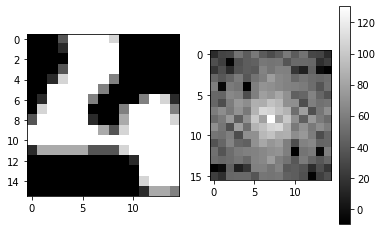

In [174]:
#this is a visualization of one of our examples. Please note that the line fshift = np.fft.fftshift(fft_data) in the code of the 
#FFT_transform in dataloader (at least in the version I use) is centering the low frequency band. So what you see here is that we
#have the highest amplitude (lightest squeres) in the center which means in the low frequency band
with open('Data/train_4.txt') as f:
    print(f)
    for line in f:
        curr = line.strip()
        mat = np.fromstring(curr, dtype=int, sep='  ')
        mat_r = np.reshape(mat, (-1, 15))
        plt.subplot(121),plt.imshow(mat_r, "gray")
        print(mat_r)
        print(len(mat_r[0]))
        print(len(mat_r))
        mag_val = FFT_transform(mat_r)
        plt.subplot(122),plt.imshow(mag_val, "gray"),plt.colorbar()
        print(mag_val)
        len(mag_val)
        print(len(mag_val[0]))
        break
    

<function matplotlib.pyplot.show(close=None, block=None)>

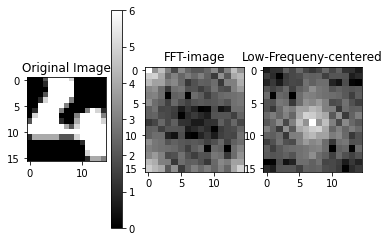

In [117]:
#to test this we use again code from the blog mentioned above to apply a low and a high pass filter to our data
original=np.fft.fft2(mat_r)
center=np.fft.fftshift(original)
#print the original image
plt.subplot(131),plt.imshow(mat_r, "gray"), plt.title("Original Image"),plt.colorbar()
#print the fast fourier transform
plt.subplot(132),plt.imshow(np.log(1+np.abs(original)), "gray"), plt.title("FFT-image")
#print the fast fourier transform with the low-frequency centered
plt.subplot(133),plt.imshow(np.log(1+np.abs(center)), "gray"), plt.title("Low-Frequeny-centered")
plt.show


(<AxesSubplot:title={'center':'Butterw. High-Pass'}>,
 Text(0.5, 1.0, 'Butterw. High-Pass'))

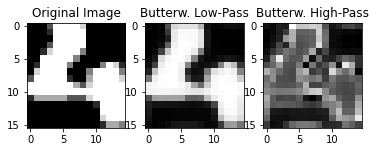

In [188]:
#here we apply a low pass gaussian filter
#LowPassCenter=center*gaussianLP(1,mat_r.shape)
LowPassCenter=center*butterworthLP(10,mat_r.shape)
LowPass=np.fft.ifftshift(LowPassCenter)
inverse_LowPass=np.fft.ifft2(LowPass)

plt.subplot(131),plt.imshow(mat_r, "gray"), plt.title("Original Image")
#we plot the reconstructed image
plt.subplot(132), plt.imshow(np.abs(inverse_LowPass),"gray"),plt.title("Butterw. Low-Pass")
#print(np.abs(LowPass)<np.abs(center))
#we plot the image in the frequency domain. You can see that the middle which corresponds to the high-pass regions are filtered out
#plt.subplot(142), plt.imshow(np.abs(LowPass),"gray"),plt.title("Low Pass-frequency")

#here we apply a high pass gaussian filter
#HighPassCenter=center*gaussianHP(1,mat_r.shape)
HighPassCenter=center*butterworthHP(10,mat_r.shape)
HighPass=np.fft.ifftshift(HighPassCenter)
inverse_HighPass=np.fft.ifft2(HighPass)
#we plot the reconstructed image
plt.subplot(133), plt.imshow(np.abs(inverse_HighPass),"gray"),plt.title("Butterw. High-Pass")

#we plot the image in the frequency domain. You can see that everything but the middle which corresponds to the high-pass regions are filtered out
#plt.subplot(144), plt.imshow(np.abs(HighPass),"gray"),plt.title("High Pass-freqeuncy")

(<AxesSubplot:title={'center':'Butterw. High-Pass'}>,
 Text(0.5, 1.0, 'Butterw. High-Pass'))

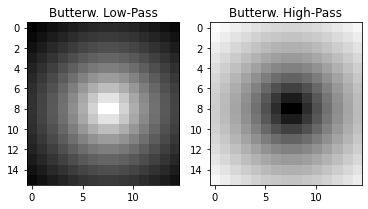

In [189]:
M,N=mat_r.shape
H=np.zeros((M,N), dtype=np.float32)
D0=10
n=0.5
for u in range(M):
    for v in range(N):
        D=np.sqrt((u-M/2)**2+(v-N/2)**2)
        H[u,v]=1/(1+(D/D0)**(2*n))
        
plt.imshow(H,cmap='gray')
plt.subplot(121),plt.imshow(butterworthLP(10,mat_r.shape),cmap='gray'),plt.title("Butterw. Low-Pass")
plt.subplot(122),plt.imshow(butterworthHP(10,mat_r.shape),cmap='gray'),plt.title("Butterw. High-Pass")
#print(mat_r)
#print((np.around(np.abs(inverse_LowPass))))
#print(mat_r==(np.around(np.abs(inverse_LowPass))))
#plt.imshow(gaussianLP(2,(10,10)), "gray")

In [46]:
#this is some experiment I started. to begin with I again process the training and test data set
import os
import pandas as pd
import numpy as np
from visualise import plot_digi_fig
import matplotlib.pyplot as plt
from dataloader import FFT_transform
#from dataloader import FFT_transform_PM

entries = os.listdir('Data/')
#print(entries)
train_data=[k for k in entries if 'train' in k]
#print(train_data)
X_title_train=[]
flat_data_train=[]
X_data_train = []
X_data_train_phase=[]
flat_data_train_phase=[]
for entry in train_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))

            #here we apply the FFT transform
            mag_val = FFT_transform(mat_r)
            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_train.append(mag_val)
            X_data_train_phase.append(phase_val)
            X_title_train.append(name)
            flat_data_train.append(mag_val.flatten())
            flat_data_train_phase.append(phase_val.flatten())
    #X_data_train.append(mag_val)
    #X_data.append (image)
test_data=[k for k in entries if 'test' in k]
#print(test_data)
X_title_test=[]
X_data_test = []
flat_data_test=[]
X_data_test_phase=[]
flat_data_test_phase=[]
for entry in test_data:
    name=entry
    #print(entry)
    with open('Data/'+name) as f:
        #print(f)
        for line in f:
            curr = line.strip()
            mat = np.fromstring(curr, dtype=int, sep='  ')
            mat_r = np.reshape(mat, (-1, 15))


            mag_val = FFT_transform(mat_r)
            mag_val,phase_val = FFT_transform_PM(mat_r)
            #break
            X_data_test.append(mag_val)
            X_data_test_phase.append(phase_val)
            X_title_test.append(name)
            flat_data_test.append(mag_val.flatten())
            flat_data_test_phase.append(phase_val.flatten())
    #X_data.append (image)


#calculate the labels of the data
res_train=[]
res_train = [sub.replace('.txt', '') for sub in X_title_train]
res_train = [sub.replace('train_', '') for sub in res_train]
res_train = [eval(i) for i in res_train]
X_train_lable=res_train
res_test=[]
res_test = [sub.replace('.txt', '') for sub in X_title_test]
res_test = [sub.replace('test_', '') for sub in res_test]
res_test = [eval(i) for i in res_test]
X_test_lable=res_test
#print(res_test)
#print(X_title_train)

#train a simple ML algorithm here SVM:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import math
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore') # I use that here as the GridSearchCV function generates a number of warning cluttering your console

# param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
param_grid={'C':[0.1,100],'gamma':[0.0001,0.001],'kernel':['poly']}

svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)
model2=GridSearchCV(svc,param_grid)

x_train=flat_data_train
x_train_phase= flat_data_train_phase # added the phase values 
#here I just convert nan to numbers but we might want to look deeper into where the nan values are coming from in the first place
x_train=np.nan_to_num(x_train)
x_train_phase = np.nan_to_num(x_train_phase)
#print(len(flat_data_train))
y_train=X_train_lable
#print(len(y_train))
x_test=flat_data_test
x_test_phase = flat_data_test_phase
x_test=np.nan_to_num(x_test)
x_test_phase= np.nan_to_num(x_test_phase)
y_test=X_test_lable

In [66]:
#print(x_train)
print((max(x_train[:,112])))
print((evaluation_array[112]))
print((evaluation_array[142]))

109.72951843985658
0.0
0.0


In [59]:
#here the question is what happens if we evaluate how a simple logistic classifier performs if we leave out one frequency?

feature_evaluation_array=np.zeros(240)
for i in range(240):
    del_x_train=x_train.copy()
    del_x_train=np.delete(del_x_train,i,1)

    del_x_test=x_test.copy()
    del_x_test=np.delete(del_x_test,i,1)

    logR = LogisticRegression()
    #logR2= LogisticRegression()
    #parameters_lr = {
        #'penalty' : ['l1','l2'], 
        #'C'       : np.logspace(-3,3,7),
        #'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],}

    #lrGrid1 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # here I only selected 2 iteration of the CV as higher values significantly increase the computation time
    #lrGrid2 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # See above

    #lr_amp = lrGrid1
    #lr_phs = lrGrid2


    #lr_amp.fit(x_train,y_train)
    #lr_phs.fit(x_train_phase,y_train)



    #check accuracy without parameter tuning for amplitude
    test_np = logR.fit(del_x_train,y_train)
    amp_pred_np= test_np.predict(del_x_test)
    #check predictions with tunned model
    #amp_pred_p= lr_amp.predict(x_test)

    #check accuracy without parameter tuning for phase
    #test_np = logR2.fit(x_train_phase,y_train)
    #phs_pred_np= test_np.predict(x_test_phase)
    #check predictions with tunned model
    #phs_pred_p= lr_phs.predict(x_test_phase)
    feature_evaluation_array[i]=sum(amp_pred_np==y_test)/len(y_test)*100

    print("LR:for feature"+str(i))
    print(round(sum(amp_pred_np==y_test)/len(y_test)*100,1))


LR:for feature0
71.8
LR:for feature1
71.9
LR:for feature2
70.5
LR:for feature3
72.0
LR:for feature4
71.9
LR:for feature5
72.2
LR:for feature6
72.5
LR:for feature7
70.7
LR:for feature8
72.5
LR:for feature9
72.2
LR:for feature10
71.9
LR:for feature11
72.0
LR:for feature12
70.5
LR:for feature13
71.9
LR:for feature14
71.8
LR:for feature15
71.8
LR:for feature16
72.4
LR:for feature17
72.2
LR:for feature18
72.1
LR:for feature19
71.9
LR:for feature20
72.0
LR:for feature21
72.4
LR:for feature22
72.2
LR:for feature23
70.0
LR:for feature24
71.7
LR:for feature25
71.5
LR:for feature26
71.5
LR:for feature27
70.9
LR:for feature28
72.4
LR:for feature29
71.8
LR:for feature30
72.6
LR:for feature31
71.3
LR:for feature32
71.0
LR:for feature33
71.4
LR:for feature34
71.4
LR:for feature35
71.4
LR:for feature36
72.8
LR:for feature37
71.8
LR:for feature38
70.7
LR:for feature39
71.7
LR:for feature40
71.8
LR:for feature41
72.0
LR:for feature42
72.3
LR:for feature43
72.5
LR:for feature44
71.6
LR:for feature45
71.

(<matplotlib.image.AxesImage at 0x21b2f34ab20>,
 <matplotlib.colorbar.Colorbar at 0x21b2f34afa0>)

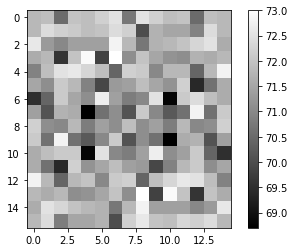

In [76]:
#I plot the accuracy for every frequency. I have to admit this is not a nice pattern.
var=feature_evaluation_array.reshape(16,15)
plt.imshow(var, "gray"),plt.colorbar()

In [62]:
#okay alternative experiment:
#here the question is what happens if we evaluate how a simple logistic classifier performs if we only use one frequency to classify the image?

feature_evaluation_array_2=np.zeros(240)
for i in range(240):
    del_x_train=x_train.copy()
    del_x_train= del_x_train[:,i]
    del_x_train=del_x_train.reshape(-1, 1)
    del_x_test=x_test.copy()
    del_x_test= del_x_test[:,i]
    del_x_test=del_x_test.reshape(-1, 1)

    logR = LogisticRegression()
    #logR2= LogisticRegression()
    #parameters_lr = {
        #'penalty' : ['l1','l2'], 
        #'C'       : np.logspace(-3,3,7),
        #'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],}

    #lrGrid1 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # here I only selected 2 iteration of the CV as higher values significantly increase the computation time
    #lrGrid2 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # See above

    #lr_amp = lrGrid1
    #lr_phs = lrGrid2


    #lr_amp.fit(x_train,y_train)
    #lr_phs.fit(x_train_phase,y_train)



    #check accuracy without parameter tuning for amplitude
    test_np = logR.fit(del_x_train,y_train)
    amp_pred_np= test_np.predict(del_x_test)
    #check predictions with tunned model
    #amp_pred_p= lr_amp.predict(x_test)

    #check accuracy without parameter tuning for phase
    #test_np = logR2.fit(x_train_phase,y_train)
    #phs_pred_np= test_np.predict(x_test_phase)
    #check predictions with tunned model
    #phs_pred_p= lr_phs.predict(x_test_phase)
    feature_evaluation_array_2[i]=sum(amp_pred_np==y_test)/len(y_test)*100

    print("LR:for feature"+str(i))
    print(round(sum(amp_pred_np==y_test)/len(y_test)*100,1))


LR:for feature0
11.5
LR:for feature1
12.3
LR:for feature2
11.8
LR:for feature3
12.5
LR:for feature4
10.9
LR:for feature5
10.8
LR:for feature6
13.3
LR:for feature7
15.8
LR:for feature8
13.3
LR:for feature9
10.8
LR:for feature10
10.9
LR:for feature11
12.5
LR:for feature12
11.8
LR:for feature13
12.3
LR:for feature14
11.5
LR:for feature15
13.0
LR:for feature16
11.0
LR:for feature17
11.1
LR:for feature18
12.3
LR:for feature19
12.5
LR:for feature20
12.9
LR:for feature21
13.5
LR:for feature22
15.4
LR:for feature23
11.6
LR:for feature24
12.3
LR:for feature25
12.0
LR:for feature26
13.1
LR:for feature27
14.6
LR:for feature28
12.4
LR:for feature29
12.5
LR:for feature30
12.5
LR:for feature31
10.9
LR:for feature32
13.5
LR:for feature33
14.0
LR:for feature34
12.0
LR:for feature35
10.8
LR:for feature36
12.2
LR:for feature37
13.0
LR:for feature38
12.2
LR:for feature39
11.7
LR:for feature40
14.5
LR:for feature41
13.5
LR:for feature42
15.7
LR:for feature43
10.7
LR:for feature44
11.4
LR:for feature45
12.

(<matplotlib.image.AxesImage at 0x21b2f28e400>,
 <matplotlib.colorbar.Colorbar at 0x21b2f2a9580>)

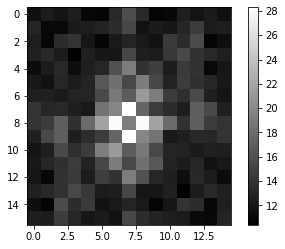

In [75]:
#again I plot the prediction accuracy for every frequency. Here the low-frequency is represented in the middle and the high frequency
#in the corners (as this is based on our original implementation). I want to claim that you can see that the high freqency is
#indeed not really important as the corners are dark.but that the low frequency is important for classifying the data
#let me know if you have an interpretation of this image
var2=feature_evaluation_array_2.reshape(16,15)
plt.imshow(var2, "gray"),plt.colorbar()

In [9]:
#because as we discussed in might be an issue to select the features also using the test-dataset I do the same thing as in the previous two
#boxes but now using cross-validation on the training dataset.
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

feature_evaluation_array_2=np.zeros(240)
for i in range(240):
    del_x_train=x_train.copy()
    del_x_train= del_x_train[:,i]
    del_x_train=del_x_train.reshape(-1, 1)
# create dataset
    X= del_x_train
    y=y_train
# prepare the cross-validation procedure
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
# create model
    model = LogisticRegression()
# evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
    print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
    del_x_train=x_train.copy()
    del_x_train= del_x_train[:,i]
    del_x_train=del_x_train.reshape(-1, 1)
    del_x_test=x_test.copy()
    del_x_test= del_x_test[:,i]
    del_x_test=del_x_test.reshape(-1, 1)

    logR = LogisticRegression()
    #logR2= LogisticRegression()
    #parameters_lr = {
        #'penalty' : ['l1','l2'], 
        #'C'       : np.logspace(-3,3,7),
        #'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],}

    #lrGrid1 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # here I only selected 2 iteration of the CV as higher values significantly increase the computation time
    #lrGrid2 = GridSearchCV(logR,
                       #param_grid = parameters_lr,
                       #scoring='accuracy',
                       #cv=2) # See above

    #lr_amp = lrGrid1
    #lr_phs = lrGrid2


    #lr_amp.fit(x_train,y_train)
    #lr_phs.fit(x_train_phase,y_train)



    #check accuracy without parameter tuning for amplitude
    test_np = logR.fit(del_x_train,y_train)
    amp_pred_np= test_np.predict(del_x_test)
    #check predictions with tunned model
    #amp_pred_p= lr_amp.predict(x_test)

    #check accuracy without parameter tuning for phase
    #test_np = logR2.fit(x_train_phase,y_train)
    #phs_pred_np= test_np.predict(x_test_phase)
    #check predictions with tunned model
    #phs_pred_p= lr_phs.predict(x_test_phase)
    feature_evaluation_array_3[i]=mean(scores)

    print("LR:for feature"+str(i))
    print(mean(scores))

Accuracy: 0.105 (0.011)
LR:for feature0
0.10500000000000001
Accuracy: 0.104 (0.007)
LR:for feature1
0.10400000000000001
Accuracy: 0.116 (0.018)
LR:for feature2
0.11600000000000002
Accuracy: 0.098 (0.012)
LR:for feature3
0.098
Accuracy: 0.084 (0.014)
LR:for feature4
0.084
Accuracy: 0.084 (0.009)
LR:for feature5
0.084
Accuracy: 0.104 (0.015)
LR:for feature6
0.10400000000000001
Accuracy: 0.144 (0.020)
LR:for feature7
0.14400000000000002
Accuracy: 0.104 (0.015)
LR:for feature8
0.10400000000000001
Accuracy: 0.084 (0.009)
LR:for feature9
0.084
Accuracy: 0.084 (0.014)
LR:for feature10
0.084
Accuracy: 0.098 (0.012)
LR:for feature11
0.098
Accuracy: 0.116 (0.018)
LR:for feature12
0.11600000000000002
Accuracy: 0.104 (0.007)
LR:for feature13
0.10400000000000001
Accuracy: 0.105 (0.011)
LR:for feature14
0.10500000000000001
Accuracy: 0.110 (0.029)
LR:for feature15
0.11000000000000001
Accuracy: 0.094 (0.017)
LR:for feature16
0.09400000000000001
Accuracy: 0.098 (0.021)
LR:for feature17
0.098
Accuracy: 

Accuracy: 0.185 (0.016)
LR:for feature156
0.185
Accuracy: 0.155 (0.028)
LR:for feature157
0.155
Accuracy: 0.178 (0.014)
LR:for feature158
0.178
Accuracy: 0.125 (0.014)
LR:for feature159
0.125
Accuracy: 0.073 (0.017)
LR:for feature160
0.073
Accuracy: 0.118 (0.017)
LR:for feature161
0.11800000000000002
Accuracy: 0.139 (0.021)
LR:for feature162
0.13899999999999998
Accuracy: 0.106 (0.019)
LR:for feature163
0.10600000000000001
Accuracy: 0.090 (0.018)
LR:for feature164
0.09
Accuracy: 0.100 (0.017)
LR:for feature165
0.1
Accuracy: 0.085 (0.023)
LR:for feature166
0.08499999999999999
Accuracy: 0.108 (0.014)
LR:for feature167
0.10799999999999998
Accuracy: 0.093 (0.030)
LR:for feature168
0.093
Accuracy: 0.101 (0.021)
LR:for feature169
0.101
Accuracy: 0.147 (0.022)
LR:for feature170
0.147
Accuracy: 0.131 (0.019)
LR:for feature171
0.131
Accuracy: 0.125 (0.012)
LR:for feature172
0.125
Accuracy: 0.147 (0.015)
LR:for feature173
0.147
Accuracy: 0.137 (0.025)
LR:for feature174
0.13699999999999998
Accurac

0.277


(<matplotlib.image.AxesImage at 0x241f0623580>,
 <matplotlib.colorbar.Colorbar at 0x241f0640850>)

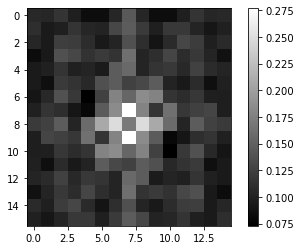

In [16]:
#the visualisation of the cross validation single feature accuracy calculation
print(max(feature_evaluation_array_3))
var3=feature_evaluation_array_3.reshape(16,15)
plt.imshow(var2, "gray"),plt.colorbar()

In [104]:
#here we select the most important features in an iterative approach we take the accuracy levels based on the previous analysis.
#Step by step we include the most, second most, third most… important feature into the analysis. If the accuracy of the logistic
#regression model increases we keep the feature otherwise we continue with the evaluation of the next feature. LOOCV leads to 
#the selection of these 25 features:[112, 126, 128, 127, 115, 52, 124, 130, 67, 187, 97, 157, 22, 84, 110, 7, 92, 162, 37, 47, 82, 95, 172, 79, 6]


evaluation_array=feature_evaluation_array_3.copy()
del_x_train=[]
features=[]
for j in range(0,239):
    if j==0:
        index_max = np.argmax(evaluation_array)
        score_temp=evaluation_array[index_max]
        print(score_temp)
        evaluation_array[index_max]=0
        del_x_this=x_train.copy()
        del_x_this= del_x_this[:,index_max]
        #print(del_x_this)
        del_x_train=del_x_this.reshape(-1, 1)
        #print(del_x_train)
        print(index_max)
        print(min(evaluation_array))
        features.append(index_max)
    else:
        index_max = np.argmax(evaluation_array)
        evaluation_array[index_max]=0
        del_x_this=x_train.copy()
        del_x_this= del_x_this[:,index_max]
        #print(del_x_this)
        del_x_this=del_x_this.reshape(-1, 1)
        #print(del_x_this)
        del_temp=np.hstack((del_x_train, del_x_this))
        #print(del_temp)
        print(index_max)
        X= del_temp
        y=y_train
        # prepare the cross-validation procedure
        #cv = KFold(n_splits=10, random_state=1, shuffle=True)
        cv = LeaveOneOut()
        # create model
        model = LogisticRegression()
        # evaluate model
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        if(mean(scores)>score_temp):
            score_temp=mean(scores)
            del_x_train=del_temp
            features.append(index_max)
            print(score_temp)
            
        
    
    
print(features)
print(score_temp)
print(len(features))

0.277
112
0.0
142
126
0.392
128
0.399
125
129
98
156
111
143
96
99
113
141
155
158
127
0.409
115
0.437
139
52
0.476
202
124
0.478
130
0.497
67
0.506
187
0.513
97
0.591
157
0.596
66
188
22
0.614
81
84
0.615
122
132
170
173
232
110
0.631
144
7
0.637
92
0.638
162
0.643
37
0.649
47
0.65
207
217
80
174
83
171
21
48
206
233
41
213
55
118
136
199
72
121
133
182
82
0.656
95
0.658
159
172
0.666
117
137
32
222
42
212
33
221
23
231
50
77
120
134
177
204
26
93
161
228
25
57
70
184
197
229
102
152
116
138
2
12
62
192
100
114
140
154
18
236
69
106
148
185
78
176
51
203
49
205
15
38
216
239
54
107
147
200
34
56
198
220
101
153
73
87
167
181
40
214
44
210
91
163
0
14
71
79
0.667
175
183
1
6
0.676
8
13
19
30
224
235
27
36
53
64
74
123
131
180
190
201
218
227
58
68
186
196
20
85
169
234
61
63
89
105
149
165
191
193
29
225
3
11
17
24
43
103
151
211
230
237
104
119
135
150
65
189
16
238
31
60
75
179
194
223
35
46
86
168
208
219
28
108
146
226
90
164
39
215
59
195
76
88
166
178
4
5
9
10
45
209
109
145
94
[

(<matplotlib.image.AxesImage at 0x241f789fb80>,
 <matplotlib.colorbar.Colorbar at 0x241f78bdeb0>)

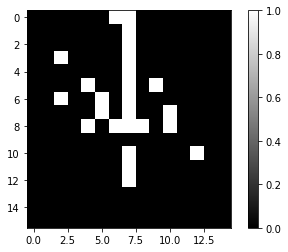

In [197]:
#we calculate a filter. For the 25 most important features we set the value to 1 for all other features to 0
arr=np.zeros(240)
for k in range(0,len(features)):
    ind=features[k]
    arr[ind]=1
#print(arr)
arr=arr.reshape(16,15)
plt.imshow(arr, "gray"),plt.colorbar()
    

(<AxesSubplot:title={'center':'manual Filter'}>,
 Text(0.5, 1.0, 'manual Filter'))

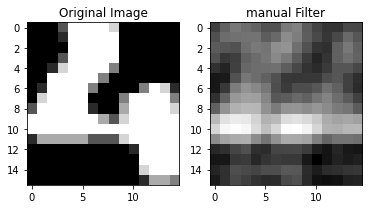

In [196]:
#when applying this manual filter to the data we get the following visualisations
Manfilter_center=center*arr
Manfilter=np.fft.ifftshift(Manfilter_center)
inverse_Manfilter=np.fft.ifft2(Manfilter)
plt.subplot(121),plt.imshow(mat_r, "gray"), plt.title("Original Image")
plt.subplot(122),plt.imshow(np.abs(inverse_Manfilter), "gray"), plt.title("manual Filter")

In [198]:
#I find it a little puzzeling that features 112 and 142 seem to be identical in the trainingsdataset.
x_train[:,112]==x_train[:,142]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,